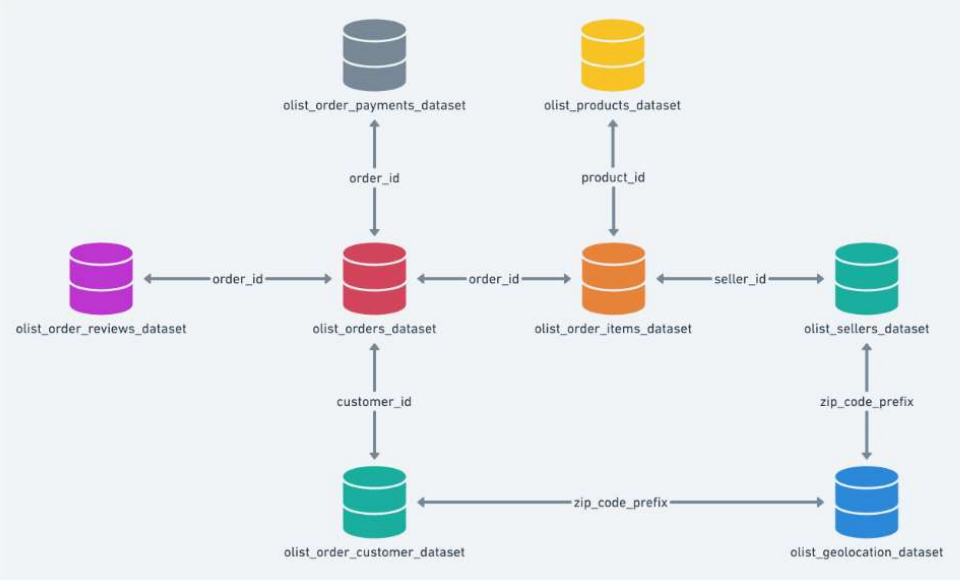

In [ ]:
#Autoriza o uso do Drive no código
from google.colab import drive
drive.mount('/content/drive')

#Importa bibliioteca para calculo ideal de número de clusters automático para fazer o calculo dinámico na função
!pip install autoelbow
from autoelbow_rupakbob import autoelbow


#bibliotecas para tratamentos de dados
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


#Bibliotecas para clusterização
from sklearn.cluster import KMeans
from sklearn import metrics


#Para análise de sentimentos
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score


# instalar as dependências do PySpark
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-2.4.4/spark-2.4.4-bin-hadoop2.7.tgz
!tar xf spark-2.4.4-bin-hadoop2.7.tgz

# configurar as variáveis de ambiente e o Spark
import os

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.4-bin-hadoop2.7"

!pip install -q findspark

# tornar o pyspark "importável"
import findspark
findspark.init('spark-2.4.4-bin-hadoop2.7')

# iniciar uma sessão local
from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local[*]").appName("DadosLoja").getOrCreate()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#Criação das funções do projeto

#Utiliza a função data para criar o Dataframe
#parâmetro 1 - Deve ser inserido o caminho do arquivo csv a ser importado
#parâmetro 2 - Deve ser inserido o separador dos dados que está sendo utilizado, normalmente ;
#parâmetro 3 - o nome que a tabela vai receber virtualmente
#parâmetro 4 - caso pretenda remover valores nulos utilizando-se de colunas específicas
def data(caminho,separador=';',nome="df",remove_na=[]):

  # cRealiza o carregamento dos dados
  df = spark.read.csv(caminho, inferSchema=True, header=True, sep=separador)


  for x in remove_na:
    df=df.na.drop(subset=x)

  # Cria ou substitui uma exibição temporária local por este DataFrame.
  df.createOrReplaceTempView(nome)

  # Returna o DataFrame criado
  return df


#Clusteriza dados, utilizando de duas colunas, uma para X e outra para Y através de uma consulta sql
#Caso queira salvar os dados na tabela original virtual, coloque o nome dela em clusDest
def xy(sql,clusDest="",n=0):

  #para diminuir a randomicidade do algoritmo de clusterização
  SEED=0
  
  #Obtem o nome das colunas da tabela
  colunas=spark.sql(sql).select("*").columns 

  #transforma os dados da tabela para variaveis
  table= np.array(spark.sql(sql).select("*").collect()) 
  flip=[list(i) for i in zip(*table)]

  #criação do gráfico de dados normais
  plt.scatter(flip[0], flip[1])
  plt.title('Data', loc='left', fontsize=18)
  plt.xlabel(colunas[0])
  plt.ylabel(colunas[1])
  marker=11
  plt.show()


  #Obtem um número ideal de clusters
  data = list(zip(flip[0], flip[1]))
  if (n<=0):
    n =autoelbow.auto_elbow_search(data)

  plt.title('Cluster', loc='left', fontsize=18)

  #Criação do clusterizador
  kmeans = KMeans(n_clusters=n,random_state=SEED)
  kmeans.fit(data)

  #Mostrar o gráfico clusterizado
  points=plt.scatter(flip[0], flip[1], c=kmeans.labels_, alpha = 0.5)


  plt.xlabel(colunas[0])
  plt.ylabel(colunas[1])

  plt.show()


  #Caso um destino para o cluster seja dado, insere ele na tabela de destino
  if (clusDest!=""):
    spark.createDataFrame(pd.DataFrame(kmeans.labels_,columns=["cluster"])).createOrReplaceTempView("clus")
    spark.sql("select ROW_NUMBER() OVER(ORDER BY (SELECT NULL)) AS id,* from clus").createOrReplaceTempView("clus")
    spark.sql("select ROW_NUMBER() OVER(ORDER BY (SELECT NULL)) AS id,* from "+clusDest).drop("cluster").createOrReplaceTempView(clusDest)
    spark.sql("SELECT A.*,B.cluster from "+clusDest+" A join clus B using(id)").drop("id").createOrReplaceTempView(clusDest)


#Salva uma tabela através de uma consulta sql com um separador padrão de virgula
def save(sql,separador=","):
  spark.sql(sql).coalesce(1).write.option("header","true").option("sep",separador).mode("overwrite").csv("Data_Table")


#Mostra as colunas de uma tabela
def showColumns(table):
  data=spark.sql("SELECT * from "+table)

  print(table," : ",data.count())
  print(data.columns,sep="")
  print("")


#Função que exibe um gráfico de barras da coluna escolhida
def grafico(var,df,total=10):

  dados=spark.sql("SELECT "+str(var)+" as nomes,count("+str(var)+") as qtds from "+df+" where "+var+"!='None' group by "+var+" order by qtds desc,nomes limit "+str(total))

  nomes=[]
  qtds=[]

  #transforma os valores em vetor
  for val in dados.select("nomes").collect(): nomes.extend(val)
  for val in dados.select("qtds").collect(): qtds.extend(val)

  #Prepara o visual do gráfico e plota ele
  fig,ax = plt.subplots(figsize=(19,8))
  
  ax.barh(nomes,qtds,color=["orange","red","blue","yellow","gray","pink","Brown","green","lime","purple"])
  ax.set_title(var,fontsize=18)

  for idx, val in enumerate(qtds):
    txt = val
    y_coord=idx-0.1
    x_coord=val

    ax.text(x=x_coord,y=y_coord,s=txt,fontsize=16)

  plt.show()

#Função que exibe um gráfico de pizza da coluna escolhida
def pizza(var,df,total=10):


  dados=spark.sql("SELECT "+str(var)+" as nomes,count("+str(var)+") as qtds from "+df+" where "+var+"!='None' group by "+var+" order by qtds desc,nomes limit "+str(total))

  nomes=[]
  qtds=[]

  #transforma os valores em vetor
  for val in dados.select("nomes").collect(): nomes.extend(val)
  for val in dados.select("qtds").collect(): qtds.extend(val)

  #Prepara o visual do gráfico e plota ele
  fig1, ax1 = plt.subplots()
  ax1.pie(qtds,  labels=nomes, autopct='%1.1f%%',colors=["orange","red","blue","yellow","gray","pink","Brown","green","lime","purple"],
          startangle=90)
  ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

  plt.show()

In [ ]:
#Importa a data de todas as planilhas
customers = data('/content/drive/MyDrive/COLLAB/Data/olist_customers_dataset.csv', separador=',', nome="customers")
geolocation = data('/content/drive/MyDrive/COLLAB/Data/olist_geolocation_dataset.csv', separador=',', nome="geolocation_backup")
order_items = data('/content/drive/MyDrive/COLLAB/Data/olist_order_items_dataset.csv', separador=',', nome="order_items")
order_payments = data('/content/drive/MyDrive/COLLAB/Data/olist_order_payments_dataset.csv', separador=',', nome="order_payments")
order_reviews = data('/content/drive/MyDrive/COLLAB/Data/olist_order_reviews_dataset.csv', separador=',', nome="order_reviews")
orders = data('/content/drive/MyDrive/COLLAB/Data/olist_orders_dataset.csv', separador=',', nome="orders")
products = data('/content/drive/MyDrive/COLLAB/Data/olist_products_dataset.csv', separador=',', nome="products",remove_na=["product_length_cm","product_height_cm"])
sellers = data('/content/drive/MyDrive/COLLAB/Data/olist_sellers_dataset.csv', separador=',', nome="sellers")


#Atualiza geolocation com Cod agrupando os códigos e tirando as médias de lat e lng
spark.sql(
"SELECT CONCAT(geolocation_state,'_',geolocation_zip_code_prefix) as cod,"+
"avg(geolocation_lat) as lat,"+
"avg(geolocation_lng) as lng"+
" from geolocation_backup group by cod order by cod"
).createOrReplaceTempView("geolocation")

#Atualiza customers com cod,lat e long
spark.sql("SELECT *,CONCAT(customer_state,'_',customer_zip_code_prefix) as cod from customers").createOrReplaceTempView("customers")
spark.sql("SELECT * from customers A join geolocation B using(cod)").createOrReplaceTempView("customers")

#Atualiza sellers com cod,lat e long
spark.sql("SELECT *,CONCAT(seller_state,'_',seller_zip_code_prefix) as cod from sellers").createOrReplaceTempView("sellers")
spark.sql("SELECT * from sellers A join geolocation B using(cod)").createOrReplaceTempView("sellers")


In [ ]:
save("SELECT * from customers")

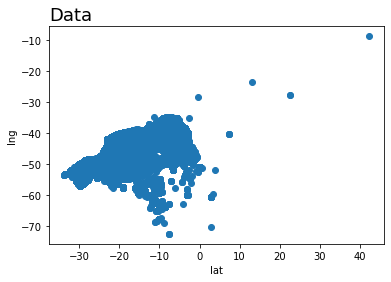

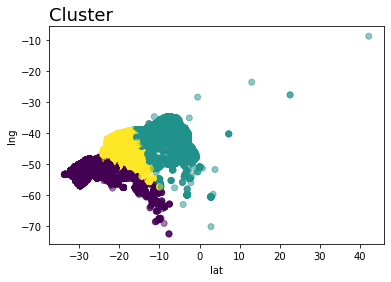

In [ ]:
#Exemplo de como uma clusterização é retornada para a tabela de origem
xy("select lat,lng from customers",clusDest="customers")


In [ ]:
#Mostra todas as colunas de cada tabela e suas respectivas quantidades de valores depois das alterações
showColumns("order_items")
showColumns("order_reviews")
showColumns("order_payments")
showColumns("orders")
showColumns("customers")
showColumns("products")
showColumns("geolocation")
showColumns("sellers")

order_items  :  112650
['order_id', 'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date', 'price', 'freight_value']

order_reviews  :  104162
['review_id', 'order_id', 'review_score', 'review_comment_title', 'review_comment_message', 'review_creation_date', 'review_answer_timestamp']

order_payments  :  103886
['order_id', 'payment_sequential', 'payment_type', 'payment_installments', 'payment_value']

orders  :  99441
['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']

customers  :  99163
['cod', 'customer_id', 'customer_unique_id', 'customer_zip_code_prefix', 'customer_city', 'customer_state', 'lat', 'lng']

products  :  32949
['product_id', 'product_category_name', 'product_name_lenght', 'product_description_lenght', 'product_photos_qty', 'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm']

geolocation  

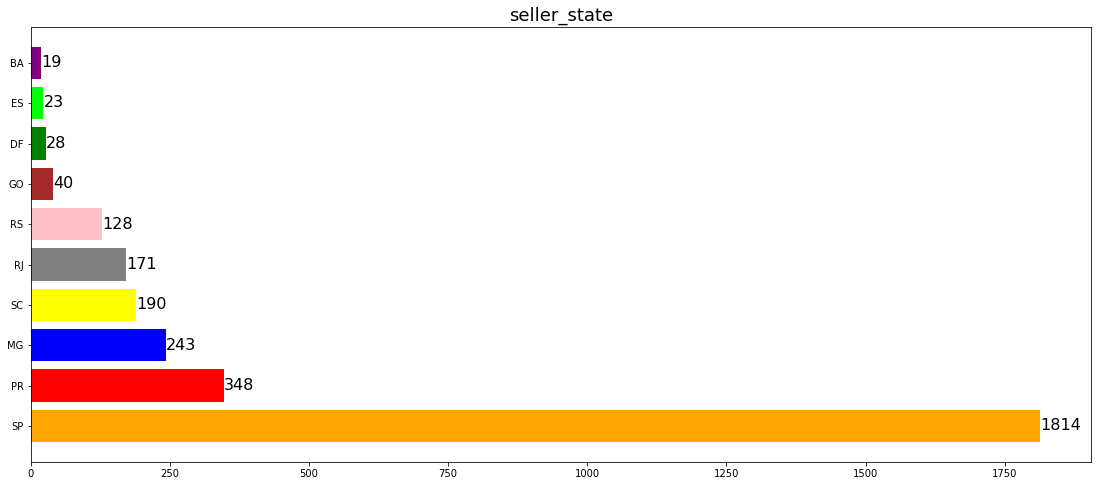

In [ ]:
#@title Plotar gráficos de Maiores Valores
data = ["sellers","seller_state"] #@param ["[\"order_reviews\",\"review_score\"]", "[\"customers\",\"customer_state\"]", "[\"sellers\",\"seller_state\"]", "[\"products\",\"product_category_name\"]"] {type:"raw"}
tipo = "Barras" #@param ["Barras", "Pizza"]

num=10

if (tipo=="Pizza"):
  pizza(data[1],data[0],total=num)
else:
  grafico(data[1],data[0],total=num)




In [ ]:
#Consulta dos maiores vendedores
spark.sql("select seller_id,B.seller_state,count(*) as qtd,round(sum(price)) as Total_price,round(sum(freight_value)) as Total_freight_value from order_items A join sellers B using (seller_id) group by seller_id,seller_state order by Total_price desc").show(10,False)

+--------------------------------+------------+----+-----------+-------------------+
|seller_id                       |seller_state|qtd |Total_price|Total_freight_value|
+--------------------------------+------------+----+-----------+-------------------+
|4869f7a5dfa277a7dca6462dcf3b52b2|SP          |1156|229473.0   |20168.0            |
|53243585a1d6dc2643021fd1853d8905|BA          |410 |222776.0   |13081.0            |
|4a3ca9315b744ce9f8e9374361493884|SP          |1987|200473.0   |35067.0            |
|fa1c13f2614d7b5c4749cbc52fecda94|SP          |586 |194042.0   |10043.0            |
|7c67e1448b00f6e969d365cea6b010ab|SP          |1364|187924.0   |51613.0            |
|7e93a43ef30c4f03f38b393420bc753a|SP          |340 |176432.0   |6322.0             |
|da8622b14eb17ae2831f4ac5b9dab84a|SP          |1551|160237.0   |24956.0            |
|7a67c85e85bb2ce8582c35f2203ad736|SP          |1171|141746.0   |20903.0            |
|1025f0e2d44d7041d6cf58b6550e0bfa|SP          |1428|138969.0   |3

In [ ]:
#Consulta dos maiores compradores
spark.sql("select customer_id,customer_state,round(sum(price)) as Total_price,round(sum(freight_value)) as Total_freight_value from orders A join order_items B using (order_id) join customers C using (customer_id) group by customer_id,customer_state order by Total_price desc").show(10,False)

+--------------------------------+--------------+-----------+-------------------+
|customer_id                     |customer_state|Total_price|Total_freight_value|
+--------------------------------+--------------+-----------+-------------------+
|1617b1357756262bfa56ab541c47bc16|RJ            |13440.0    |224.0              |
|ec5b2ba62e574342386871631fafd3fc|ES            |7160.0     |115.0              |
|c6e2731c5b391845f6800c97401a43a9|MS            |6735.0     |194.0              |
|f48d464a0baaea338cb25f816991ab1f|ES            |6729.0     |193.0              |
|3fd6777bbce08a352fddd04e4a7cc8f6|SP            |6499.0     |228.0              |
|05455dfa7cd02f13d132aa7a6a9729c6|MG            |5935.0     |147.0              |
|df55c14d1476a9a3467f131269c2477f|RJ            |4799.0     |151.0              |
|24bbf5fd2f2e1b359ee7de94defc4a15|SP            |4690.0     |74.0               |
|e0a2412720e9ea4f26c1ac985f6a7358|GO            |4600.0     |210.0              |
|3d979689f636322

In [ ]:
#Consulta dos maiores produtos em vendas
spark.sql("select product_id,product_category_name,count(*) as qtd,round(sum(price)) as Total_price,round(sum(freight_value)) as Total_freight_value from order_items A join products B using (product_id) group by product_id,product_category_name order by Total_price desc").show(10,False)

+--------------------------------+----------------------+---+-----------+-------------------+
|product_id                      |product_category_name |qtd|Total_price|Total_freight_value|
+--------------------------------+----------------------+---+-----------+-------------------+
|bb50f2e236e5eea0100680137654686c|beleza_saude          |195|63885.0    |3721.0             |
|6cdd53843498f92890544667809f1595|beleza_saude          |156|54730.0    |4364.0             |
|d6160fb7873f184099d9bc95e30376af|pcs                   |35 |48899.0    |1427.0             |
|d1c427060a0f73f6b889a5c7c61f2ac4|informatica_acessorios|343|47215.0    |13762.0            |
|99a4788cb24856965c36a24e339b6058|cama_mesa_banho       |488|43026.0    |8046.0             |
|3dd2a17168ec895c781a9191c1e95ad7|informatica_acessorios|274|41083.0    |7130.0             |
|25c38557cf793876c5abdd5931f922db|bebes                 |38 |38907.0    |1405.0             |
|5f504b3a1c75b73d6151be81eb05bdc9|cool_stuff            |63 

In [ ]:
#Consulta das categorias com maior valor de venda
spark.sql("select product_category_name,count(*) as qtd,round(sum(price)) as Total_price,round(sum(freight_value)) as Total_freight_value from order_items A join products B using (product_id) group by product_category_name order by Total_price desc").show(10,False)

+----------------------+-----+-----------+-------------------+
|product_category_name |qtd  |Total_price|Total_freight_value|
+----------------------+-----+-----------+-------------------+
|beleza_saude          |9670 |1258681.0  |182567.0           |
|relogios_presentes    |5991 |1205006.0  |100536.0           |
|cama_mesa_banho       |11115|1036989.0  |204693.0           |
|esporte_lazer         |8641 |988049.0   |168608.0           |
|informatica_acessorios|7827 |911954.0   |147318.0           |
|moveis_decoracao      |8334 |729762.0   |172749.0           |
|cool_stuff            |3796 |635291.0   |84039.0            |
|utilidades_domesticas |6964 |632249.0   |146149.0           |
|automotivo            |4235 |592720.0   |92664.0            |
|ferramentas_jardim    |4347 |485256.0   |98963.0            |
+----------------------+-----+-----------+-------------------+
only showing top 10 rows



In [ ]:
#Estados com maiores registros na tabela de Geolocation
spark.sql("select geolocation_state,count(*) as qtd,avg(geolocation_lat) as lat_avg,avg(geolocation_lng) as lng_avg from geolocation_backup group by geolocation_state order by qtd desc").show(10,False)

+-----------------+------+-------------------+------------------+
|geolocation_state|qtd   |lat_avg            |lng_avg           |
+-----------------+------+-------------------+------------------+
|SP               |404268|-23.155308346172184|-47.08407367161121|
|MG               |126336|-19.864647279116994|-44.4216150659084 |
|RJ               |121169|-22.74347732166985 |-43.15554026830323|
|RS               |61851 |-29.679190623281976|-52.03265163171481|
|PR               |57859 |-24.79360667662306 |-50.87966244315085|
|SC               |38328 |-27.222485826583682|-49.61793687268917|
|BA               |36045 |-13.049360869325763|-39.56064869603112|
|GO               |20139 |-16.577644584237582|-49.33419502806311|
|ES               |16748 |-20.105145324187312|-40.50318322322493|
|PE               |16432 |-8.179098403904238 |-35.75886555563942|
+-----------------+------+-------------------+------------------+
only showing top 10 rows



In [ ]:
#Consulta da tabela para utilizar na análise de sentimentos
spark.sql("select int(review_score) as score,review_comment_message as txt from order_reviews where review_comment_message is not null and int(review_score) is not null order by score asc ").show(10,False)

+-----+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|score|txt                                                                                                                                                                                                    |
+-----+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|1    |O produto não chegou e já faz mais de um mês que fiz o pedido!                                                                                                                                         |
|1    |Boa tarde,                                                                                                                                                       

In [ ]:
#Salva a tabela pra análise de sentimentos
save("select int(review_score) as score,review_comment_message as txt from order_reviews where review_comment_message is not null and int(review_score) is not null order by score asc",separador=";")

In [ ]:
#Gerar arquivo de compras de cada cliente para apriori

spark.sql("select order_id as id,order_item_id as num,product_id as item from order_items A join orders B using (order_id) order by order_id").createOrReplaceTempView("list")

spark.sql("select A.*,B.product_category_name as category from list A join products B on (A.item=B.product_id)").createOrReplaceTempView("list")

spark.sql("select count(DISTINCT item) as qtd,collect_set(item) as shop,collect_set(category) as categorys from list group by id having qtd>1 order by qtd desc").createOrReplaceTempView("shops")

spark.sql("select * from shops").toPandas().to_csv("dados.csv", sep=';', index = False)

Score:  0.7257364580042698


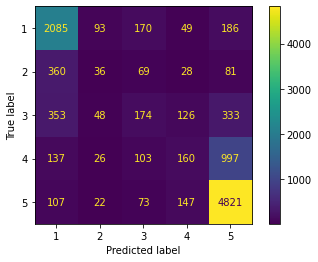

In [ ]:
#import da base para análise de sentimentos
df = pd.read_csv("/content/drive/MyDrive/COLLAB/Data/analise_sentimentos.csv", on_bad_lines='skip',sep=";")

#Criação e treinamento dos dados de teste
vect = CountVectorizer(ngram_range=(1, 1))
vect.fit(df.txt)
text_vect = vect.transform(df.txt)

X_train,X_test,y_train,y_test = train_test_split(
text_vect,
df.score,
test_size = 0.3,
random_state = 42
)

clf = LogisticRegression(random_state=0, solver='newton-cg')
clf = clf.fit(X_train, y_train)

#mostrar resultado de precisão
y_prediction = clf.predict(X_test)
f1 = f1_score(y_prediction, y_test, average='weighted')
print("Score: ",f1)


#plotar gráfico de matriz de confusão

matrix=metrics.confusion_matrix(y_test, y_prediction)

cm_display=metrics.ConfusionMatrixDisplay(confusion_matrix = matrix, display_labels = [1,2,3,4,5])

cm_display.plot()
plt.show()

In [ ]:
df.head(10)

,score,txt
0,1,Péssimo
1,1,Não gostei ! Comprei gato por lebre
2,1,Sempre compro pela Internet e a entrega ocorre...
3,1,Nada de chegar o meu pedido.
4,1,recebi somente 1 controle Midea Split ESTILO.
5,1,O produto não chegou no prazo estipulado e cau...
6,1,"Produto muito inferior, mal acabado."
7,1,Pedi reembolso e sem resposta até momento
8,1,Este foi o pedido
9,1,comprei tres pacotes de cinco folhas cada de p...


In [ ]:
#@title Predizer sentimento

comentario1 = "Odiei esse produto!" #@param {type:"string"}
comentario2 = "\"Gostei bastante do conteudo do produto\"" #@param {type:"string"}
comentario3 = "produto muito ruim :C" #@param {type:"string"}
comentario4 = "O preco estava otimo" #@param {type:"string"}
comentario5 = "Achei o produto bem p\xE9ssimo" #@param {type:"string"}


dados=pd.DataFrame({'col1': [comentario1,comentario2,comentario3,comentario4,comentario5]})


predizer = vect.transform(dados.col1)


sentimentos=["Negativo-","Negativo","Neutro","Positivo","Positivo+"]

print("(",sentimentos[clf.predict(predizer)[0]-1],")",comentario1)

print("\n(",sentimentos[clf.predict(predizer)[1]-1],")",comentario2)

print("\n(",sentimentos[clf.predict(predizer)[2]-1],")",comentario3)

print("\n(",sentimentos[clf.predict(predizer)[3]-1],")",comentario4)

print("\n(",sentimentos[clf.predict(predizer)[4]-1],")",comentario5)



( Negativo- ) Odiei esse produto!

( Positivo+ ) "Gostei bastante do conteudo do produto"

( Negativo- ) produto muito ruim :C

( Positivo+ ) O preco estava otimo

( Negativo- ) Achei o produto bem péssimo


Código R para Apriori utilizado:

```
install.packages("arules")
library(arules)

#Arquivo= "C:/Users/leloe/Desktop/apriori_itens.csv";
Arquivo= "C:/Users/leloe/Desktop/apriori_categorys.csv";

transacoes <- read.transactions(
  file= Arquivo
  , sep = ","
  , format="basket"
  , header = TRUE
  
)

regras <- apriori(transacoes, parameter= list(minlen=2, supp=0.01, conf=0.01))

inspect(regras)

```

